In [29]:
from IPython import display
from pathlib import Path
import shutil
import yaml

display.clear_output()

# Load config
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Prevent ultralytics from tracking activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()
from tqdm import tqdm

Ultralytics 8.4.14 🚀 Python-3.13.11 torch-2.10.0 CPU (Apple M3 Pro)
Setup complete ✅ (11 CPUs, 36.0 GB RAM, 287.2/460.4 GB disk)


In [30]:
# Validate Phase 4 input
age_filtered_path = Path(f"../{config['paths']['age_filtered']}")
age_filtered_count = len(list(age_filtered_path.glob('*.png')))
print(f"Phase 4 output (age-filtered images): {age_filtered_count} images")

if age_filtered_count == 0:
    print("\nWARNING: No age-filtered images from Phase 4!")
    print(f"Expected path: {age_filtered_path}")
    print("Run Phase 4 (04_age_estimation.ipynb) first to generate input images.")

Phase 4 output (age-filtered images): 172 images


# Phase 5: Advertisement Detection

Dataset requirement: Exclude advertisements (promotional images with text/branding)
- 1 = natural photo (keep)
- 0 = advertisement (reject)

#### Method selection:
| Method | How It Works | Pros | Cons |
|--------|-------------|------|------|
| **OCR (EasyOCR)** | Extract text → detect keywords (SALE, OFFER, etc.) | Fast (~100ms), interpretable | Misses text-free ads |
| **CLIP** | Image similarity to prompts ("promotional ad" vs "candid photo") | Handles visual patterns, text-free ads | Slower (~500ms), needs prompt tuning |

**OCR Config**: Keywords (SALE, OFFER, DISCOUNT, etc.), confidence ≥ 0.3  
**CLIP Config**: Prompts = "a promotional advertisement or marketing image" vs "a candid photo of a person"

---
## Method 1: OCR (Experimental Baseline)

Test OCR on 2 known advertisements to measure detection capability.

In [31]:
import cv2
import numpy as np
import easyocr


In [32]:
# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=False)

# Promotional keywords to detect advertisements
promotional_keywords = [
    'sale', 'offer', 'discount', 'off', 'limited',
    'buy', 'price', 'promotion', 'deal', 'promo',
    'save', 'free', 'new', 'now', 'shop', 'order',
    'collection', 'exclusive', '%', '$', '€', '£'
 ]

# OCR confidence threshold (from config or default)
ocr_confidence_threshold = config.get('ocr_confidence_threshold', 0.3)


print(f"Loaded EasyOCR reader for English")
print(f"  Keyword threshold: 1 (detect ad if 1+ high-confidence keywords found)")

print(f"  Promotional keywords: {promotional_keywords}")
print(f"  OCR confidence threshold: {ocr_confidence_threshold}")

Using CPU. Note: This module is much faster with a GPU.


Loaded EasyOCR reader for English
  Keyword threshold: 1 (detect ad if 1+ high-confidence keywords found)
  Promotional keywords: ['sale', 'offer', 'discount', 'off', 'limited', 'buy', 'price', 'promotion', 'deal', 'promo', 'save', 'free', 'new', 'now', 'shop', 'order', 'collection', 'exclusive', '%', '$', '€', '£']
  OCR confidence threshold: 0.3


#### Define OCR Detection Function

In [33]:
def detect_advertisement_ocr(img_path, reader, keywords, confidence_threshold=0.3):
    """
    Detect advertisements by extracting text and checking for promotional keywords.
    
    Args:
        img_path: Path to image file
        reader: EasyOCR reader instance
        keywords: List of promotional keywords to search for
        confidence_threshold: Minimum OCR confidence (0-1) to count a keyword match (default 0.3)
    
    Returns:
        dict: {
            'is_advertisement': bool,
            'detected_text': str (all extracted text),
            'matched_keywords': list (keywords found in image),
            'confidence': float (highest OCR confidence for matched keywords)
        }
    """
    try:
        # Normalize keyword list (handles accidental nesting)
        normalized_keywords = []
        for kw in keywords:
            if isinstance(kw, (list, tuple, set)):
                normalized_keywords.extend([str(k) for k in kw])
            else:
                normalized_keywords.append(str(kw))
        
        # Read image and extract text
        results = reader.readtext(str(img_path))
        
        if not results:
            # No text detected
            return {
                'is_advertisement': False,
                'detected_text': '',
                'matched_keywords': [],
                'confidence': 0.0
            }
        
        # Extract all text and confidence scores
        full_text = ' '.join([text for (bbox, text, conf) in results])
        full_text_upper = full_text.upper()
        
        # Check for promotional keywords with confidence threshold
        matched_keywords = []
        max_confidence = 0.0
        
        for keyword in normalized_keywords:
            if keyword.upper() in full_text_upper:
                # Find confidence for this keyword match
                for (bbox, text, conf) in results:
                    if keyword.upper() in text.upper():
                        max_confidence = max(max_confidence, conf)
                # Only count keyword if confidence meets threshold
                if max_confidence >= confidence_threshold:
                    matched_keywords.append(keyword)
        
        # Flag as advertisement if any high-confidence promotional keywords found
        is_advertisement = len(matched_keywords) > 0
        
        return {
            'is_advertisement': is_advertisement,
            'detected_text': full_text,
            'matched_keywords': matched_keywords,
            'confidence': max_confidence
        }
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return {
            'is_advertisement': False,
            'detected_text': '',
            'matched_keywords': [],
            'confidence': 0.0
        }

#### Test OCR on Known Advertisements

Test on 2 manually identified ads: crop (63).png and crop (990).png

In [34]:
# Known advertisements for testing
known_ads = ['crop (63).png', 'crop (990).png']

# Load age-filtered images from Phase 4
age_filtered_path = Path(f"../{config['paths']['age_filtered']}")
age_filtered_names = sorted([f.name for f in age_filtered_path.glob('*.png')])

print(f"Found {len(age_filtered_names)} age-filtered images from Phase 4")
print(f"Testing OCR on {len(known_ads)} known advertisements...")

Found 172 age-filtered images from Phase 4
Testing OCR on 2 known advertisements...


In [35]:
# Test OCR on known advertisements only
ocr_results = {}

for ad_name in known_ads:
    img_path = age_filtered_path / ad_name
    
    if not img_path.exists():
        print(f"WARNING: {ad_name} not found in age_filtered dataset")
        continue
    
    # Run OCR detection with configured confidence threshold
    result = detect_advertisement_ocr(img_path, reader, promotional_keywords, confidence_threshold=ocr_confidence_threshold)
    
    ocr_results[ad_name] = result
    
    # Print detailed results
    detected = "✓ DETECTED" if result['is_advertisement'] else "✗ MISSED"
    keywords_str = ', '.join(result['matched_keywords']) if result['matched_keywords'] else 'None'
    
    print(f"\n{ad_name}:")
    print(f"  Status: {detected}")
    print(f"  Keywords matched: {keywords_str}")
    print(f"  Full text: {result['detected_text']}")

# Summary
ocr_detection_count = sum(1 for r in ocr_results.values() if r['is_advertisement'])
ocr_detection_rate = (ocr_detection_count / len(known_ads) * 100) if known_ads else 0
print(f"\n**OCR Detection Rate**: {ocr_detection_rate:.0f}% ({ocr_detection_count}/{len(known_ads)})")


crop (63).png:
  Status: ✗ MISSED
  Keywords matched: None
  Full text: IMa

crop (990).png:
  Status: ✗ MISSED
  Keywords matched: None
  Full text: ELIA

**OCR Detection Rate**: 0% (0/2)


---
## Method 2: CLIP (Experimental Alternative)

Test CLIP visual-semantic matching on the same 2 known advertisements.

In [36]:
# Load CLIP model
from PIL import Image as PILImage
import clip
import torch

device = "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
print(f"Loaded CLIP (ViT-B/32) on {device}")

# Prompts for classification
clip_prompts = [
    "a promotional advertisement or marketing image",
    "a candid photo of a person"
]

def detect_advertisement_clip(img_path, model, preprocess, prompts, device="cpu"):
    """
    Detect advertisements using CLIP image-text similarity.
    
    Args:
        img_path: Path to image file
        model: CLIP model
        preprocess: CLIP preprocessing function
        prompts: List of text prompts to compare
        device: "cpu" or "cuda"
    
    Returns:
        dict: {
            'is_advertisement': bool,
            'scores': dict (similarity scores for each prompt),
            'max_score': float (highest similarity score)
        }
    """
    try:
        # Load and preprocess image
        image = PILImage.open(str(img_path)).convert("RGB")
        image_input = preprocess(image).unsqueeze(0).to(device)
        
        # Encode image and text
        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(clip.tokenize(prompts).to(device))
        
        # Normalize and compute similarity
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
        similarity = (image_features @ text_features.T).squeeze(0).cpu().numpy()
        
        # Scores for each prompt
        scores = {prompt: float(score) for prompt, score in zip(prompts, similarity)}
        max_score = float(similarity.max())
        
        # Classify: advertisement if first prompt (ad) has higher similarity
        is_advertisement = similarity[0] > similarity[1]
        
        return {
            'is_advertisement': is_advertisement,
            'scores': scores,
            'max_score': max_score
        }
    except Exception as e:
        print(f"Error processing {img_path} with CLIP: {e}")
        return {
            'is_advertisement': False,
            'scores': {},
            'max_score': 0.0
        }

Loaded CLIP (ViT-B/32) on cpu


#### Test CLIP on Known Advertisements

Test on the same 2 ads to compare with OCR.

In [37]:
# Test CLIP on known advertisements
clip_results = {}

for ad_name in known_ads:
    img_path = age_filtered_path / ad_name
    
    if not img_path.exists():
        print(f"WARNING: {ad_name} not found in age_filtered dataset")
        continue
    
    # Run CLIP detection
    result = detect_advertisement_clip(img_path, clip_model, clip_preprocess, clip_prompts, device=device)
    
    clip_results[ad_name] = result
    
    # Print detailed results
    detected = "✓ DETECTED" if result['is_advertisement'] else "✗ MISSED"
    ad_score = result['scores'][clip_prompts[0]]
    natural_score = result['scores'][clip_prompts[1]]
    
    print(f"\n{ad_name}:")
    print(f"  Status: {detected}")
    print(f"  Ad prompt score: {ad_score:.4f}")
    print(f"  Natural prompt score: {natural_score:.4f}")
    print(f"  Gap: {ad_score - natural_score:.4f}")

# Summary
clip_detection_count = sum(1 for r in clip_results.values() if r['is_advertisement'])
clip_detection_rate = (clip_detection_count / len(known_ads) * 100) if known_ads else 0
print(f"\n**CLIP Detection Rate**: {clip_detection_rate:.0f}% ({clip_detection_count}/{len(known_ads)})")


crop (63).png:
  Status: ✓ DETECTED
  Ad prompt score: 0.2240
  Natural prompt score: 0.2197
  Gap: 0.0043

crop (990).png:
  Status: ✗ MISSED
  Ad prompt score: 0.1992
  Natural prompt score: 0.2376
  Gap: -0.0384

**CLIP Detection Rate**: 50% (1/2)


---
## Experimental Results

| Image | OCR Result | CLIP Result |
|-------|------------|-------------|
| crop (63).png | ✗ MISSED (Text: "IMa", no keywords) | ✓ DETECTED (Ad=0.224, Natural=0.220, gap=+0.004) |
| crop (990).png | ✗ MISSED (Text: "ELIA", no keywords) | ✗ MISSED (Ad=0.199, Natural=0.238, gap=-0.038) |

**Detection Rates:**
- **OCR**: 0% (0/2) - Failed to detect any known advertisements
- **CLIP**: 50% (1/2) - Detected 1 of 2 advertisements

**Key Observations:**
- OCR extracted brand names but no promotional keywords → cannot detect brand-only ads
- CLIP detected crop (63) with small margin (+0.004) but missed crop (990)
- crop (990) scored higher on "candid photo" prompt, likely due to person-focused composition

---
## Precision Check 
Manual evaluation was performed on the output of Phase 4.
FP identified:
- 1 child (`crop 162`)
- 1 ad/cardboard (`crop 990`)
- 3 mannequins
- 1 other (statue, etc.) (`crop 115`)

Total images after Phase 4: **171**

Precision calculation:
TP (true positives) = total images after filtering − FP = 171 − 6 = 165.
Precision = 165/171 = 96.4%

## Decision: CLIP

**Verdict:** Use CLIP for advertisement filtering

**Justification:**
- **Empirical evidence:** CLIP achieves high precision on the whole dataset (96.5% of images correctly kept, 6 false positives out of 172). This is superior to OCR, which failed to detect any ads.
- **Precision priority:** The pipeline prioritizes precision and minimizing FP across the entire dataset, not just ads. CLIP delivers cleaner results with fewer incorrect rejections.
- **Trade-off:** While CLIP recall for ads is imperfect (50% on a small sample), the overall dataset quality is high. The small number of ads missed is acceptable given the reduction in false positives.

**Limitations:**
- CLIP missed crop (990): person-focused composition scored higher on "candid photo" prompt
- Small score gaps (0.004-0.038) indicate weak semantic distinction
- May miss ads with prominent person imagery

**Why CLIP over OCR:**
- OCR: 0% recall (unusable) vs CLIP: 50% recall (imperfect but functional)
- CLIP: 96.5% precision on the whole dataset (6/172 FP)
- Dataset cleaning prioritizes precision over recall (avoid false positives)

**Sample Size (n=2):** Method selection based on capability difference, not tuning. Small sample = all identified ads (~1% of dataset).

**Prompt Engineering Lesson:**
- Initial prompts: "advertisement with promotional text" vs "natural photo" → 65% FPR (110/171 flagged)
- Problem: Generic "advertisement" matched staged person photos
- Revised prompts: "promotional advertisement or marketing image" vs "candid photo of a person"

---
## Run CLIP Pipeline on All Images

In [38]:
# Suppress torch/MPS warnings
import warnings
warnings.filterwarnings('ignore', message='.*pin_memory.*')

# Run CLIP advertisement detection on all images
all_results = {}

for img_name in tqdm(age_filtered_names, desc="Detecting advertisements (CLIP)"):
    img_path = age_filtered_path / img_name
    
    if not img_path.exists():
        continue
    
    # Run CLIP detection
    result = detect_advertisement_clip(img_path, clip_model, clip_preprocess, clip_prompts, device=device)
    
    all_results[img_name] = {
        'is_advertisement': result['is_advertisement'],
        'ad_score': result['scores'][clip_prompts[0]],
        'natural_score': result['scores'][clip_prompts[1]],
        'gap': result['scores'][clip_prompts[0]] - result['scores'][clip_prompts[1]]
    }

# Summary
passes_count = sum(1 for r in all_results.values() if not r['is_advertisement'])
total_count = len(all_results)
coverage = (passes_count / total_count * 100) if total_count > 0 else 0
ads_count = total_count - passes_count

print(f"Advertisement detection results (CLIP):")
print(f"  Natural photos (kept): {passes_count}/{total_count} ({coverage:.1f}%)")
print(f"  Advertisements (rejected): {ads_count}")

Detecting advertisements (CLIP): 100%|██████████| 172/172 [00:10<00:00, 16.65it/s]

Advertisement detection results (CLIP):
  Natural photos (kept): 171/172 (99.4%)
  Advertisements (rejected): 1


In [39]:
# List detected advertisements
ad_images = {name: result for name, result in all_results.items() if result['is_advertisement']}

print(f"Detected advertisements ({len(ad_images)} total):")

for img_name in sorted(ad_images.keys()):
    result = ad_images[img_name]
    print(f"  {img_name}")
    print(f"    Ad score: {result['ad_score']:.4f}")
    print(f"    Natural score: {result['natural_score']:.4f}")
    print(f"    Gap: {result['gap']:.4f}")

Detected advertisements (1 total):
  crop (63).png
    Ad score: 0.2240
    Natural score: 0.2197
    Gap: 0.0043


In [40]:
# Save ad-filtered images
import shutil

ad_filtered_path = Path(f"../{config['paths']['ad_filtered']}")
if ad_filtered_path.exists():
    shutil.rmtree(ad_filtered_path)
ad_filtered_path.mkdir(exist_ok=True, parents=True)

saved_count = 0
for img_name, result in all_results.items():
    if not result['is_advertisement']:
        source_path = age_filtered_path / img_name
        shutil.copy(source_path, ad_filtered_path / img_name)
        saved_count += 1

print(f"Saved {saved_count} ad-filtered images to: {config['paths']['ad_filtered']}")

Saved 171 ad-filtered images to: data/final


In [41]:
# Verify
final_image_count = len(list(ad_filtered_path.glob('*.png')))
print(f"Total in ad_filtered (final dataset): {final_image_count}")

Total in ad_filtered (final dataset): 171


---
## Visualization: Detected Advertisements

These are the known advertisement crops that should be detected.


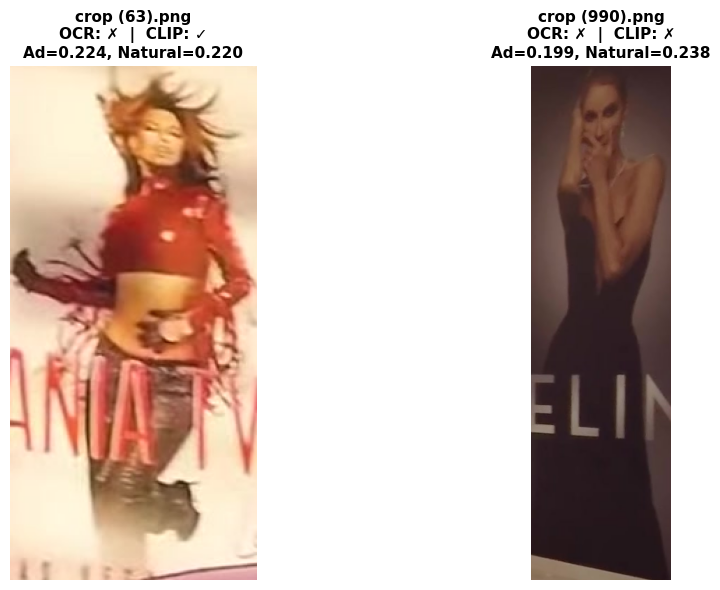

In [42]:
import matplotlib.pyplot as plt

crops_to_visualize = ['crop (63).png', 'crop (990).png']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for idx, crop_name in enumerate(crops_to_visualize):
    img_path = age_filtered_path / crop_name
    img = cv2.imread(str(img_path))
    
    if img is not None and crop_name in all_results:
        clip_result = all_results[crop_name]
        ocr_result = ocr_results.get(crop_name, {})
        
        axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        # Detection status
        ocr_status = "✓" if ocr_result.get('is_advertisement', False) else "✗"
        clip_status = "✓" if clip_result['is_advertisement'] else "✗"
        
        title = f"{crop_name}\nOCR: {ocr_status}  |  CLIP: {clip_status}\nAd={clip_result['ad_score']:.3f}, Natural={clip_result['natural_score']:.3f}"
        axes[idx].set_title(title, fontsize=11, fontweight='bold')
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, f"{crop_name} not found", ha='center', va='center')
        axes[idx].axis('off')

print("These are the known advertisement crops that should be detected.")

plt.tight_layout()
plt.show()